In [1]:
#import all libraries
from tqdm import tqdm
import os
import time
from random import randint
import numpy as np
from scipy import stats
import pandas as pd

import seaborn as sns
import imageio

from skimage.transform import resize
from skimage.util import montage
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.animation as anim
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec

import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn import MSELoss

import albumentations as A
from albumentations import Compose, HorizontalFlip
#from albumentations.pytorch import ToTensor, ToTensorV2 

import nibabel as nib
import h5py

/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.21). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
import os
import pandas as pd

# Define paths to train and validation folders
train_dir = '/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData'
val_dir = '/kaggle/input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData'      

def create_dataframe(data_dir):
    data = []
    for patient_folder in os.listdir(data_dir):
        folder_path = os.path.join(data_dir, patient_folder)
        if os.path.isdir(folder_path):
            patient_id = patient_folder
            data.append({
                'Brats20ID': patient_id,
                'path': folder_path
            })
    return pd.DataFrame(data)

# Create DataFrames for train and validation sets
train_df = create_dataframe(train_dir)
test_df = create_dataframe(val_dir)

# Preview DataFrames
print("Train DataFrame:\n", train_df.head())
print("\nTest DataFrame:\n", test_df.head())

Train DataFrame:
               Brats20ID                                               path
0  BraTS20_Training_083  /kaggle/input/brats20-dataset-training-validat...
1  BraTS20_Training_337  /kaggle/input/brats20-dataset-training-validat...
2  BraTS20_Training_161  /kaggle/input/brats20-dataset-training-validat...
3  BraTS20_Training_198  /kaggle/input/brats20-dataset-training-validat...
4  BraTS20_Training_284  /kaggle/input/brats20-dataset-training-validat...

Test DataFrame:
                 Brats20ID                                               path
0  BraTS20_Validation_084  /kaggle/input/brats20-dataset-training-validat...
1  BraTS20_Validation_118  /kaggle/input/brats20-dataset-training-validat...
2  BraTS20_Validation_111  /kaggle/input/brats20-dataset-training-validat...
3  BraTS20_Validation_060  /kaggle/input/brats20-dataset-training-validat...
4  BraTS20_Validation_034  /kaggle/input/brats20-dataset-training-validat...


In [3]:
class BratsDataset(Dataset):
    def __init__(self, df: pd.DataFrame, phase: str="test", is_resize: bool=False):
        self.df = df
        self.phase = phase
        self.augmentations = get_augmentations(phase)
        self.data_types = ['_flair.nii', '_t1.nii', '_t1ce.nii', '_t2.nii']
        self.is_resize = is_resize
        
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
        id_ = self.df.loc[idx, 'Brats20ID']
        root_path = self.df.loc[self.df['Brats20ID'] == id_]['path'].values[0]
        # load all modalities
        images = []
        for data_type in self.data_types:
            img_path = os.path.join(root_path, id_ + data_type)
            img = self.load_img(img_path)#.transpose(2, 0, 1)
            
            if self.is_resize:
                img = self.resize(img)
    
            img = self.normalize(img)
            images.append(img)
        img = np.stack(images)
        img = np.moveaxis(img, (0, 1, 2, 3), (0, 3, 2, 1))
        
        if self.phase != "test":
            mask_path =  os.path.join(root_path, id_ + "_seg.nii")
            mask = self.load_img(mask_path)
            
            if self.is_resize:
                mask = self.resize(mask)
                mask = np.clip(mask.astype(np.uint8), 0, 1).astype(np.float32)
                mask = np.clip(mask, 0, 1)
            mask = self.preprocess_mask_labels(mask)
    
            augmented = self.augmentations(image=img.astype(np.float32), 
                                           mask=mask.astype(np.float32))
            
            img = augmented['image']
            mask = augmented['mask']
        
            return {
                "Id": id_,
                "image": img,
                "mask": mask,
            }
        
        return {
            "Id": id_,
            "image": img,
        }
    
    def load_img(self, file_path):
        data = nib.load(file_path)
        data = np.asarray(data.dataobj)
        return data
    
    def normalize(self, data: np.ndarray):
        data_min = np.min(data)
        return (data - data_min) / (np.max(data) - data_min)
    
    def resize(self, data: np.ndarray):
        data = resize(data, (78, 120, 120), preserve_range=True)
        return data
    
    def preprocess_mask_labels(self, mask: np.ndarray):

        mask_WT = mask.copy()
        mask_WT[mask_WT == 1] = 1
        mask_WT[mask_WT == 2] = 1
        mask_WT[mask_WT == 4] = 1

        mask_TC = mask.copy()
        mask_TC[mask_TC == 1] = 1
        mask_TC[mask_TC == 2] = 0
        mask_TC[mask_TC == 4] = 1

        mask_ET = mask.copy()
        mask_ET[mask_ET == 1] = 0
        mask_ET[mask_ET == 2] = 0
        mask_ET[mask_ET == 4] = 1

        mask = np.stack([mask_WT, mask_TC, mask_ET])
        mask = np.moveaxis(mask, (0, 1, 2, 3), (0, 3, 2, 1))

        return mask

In [4]:
# Losses and Metrics 
def dice_coef_metric(probabilities, truth, threshold=0.5, eps=1e-7):
    """
    Calculate the Dice coefficient for given probabilities and truth masks.
    
    Args:
        probabilities (torch.Tensor): Predicted probabilities.
        truth (torch.Tensor): Ground truth masks.
        threshold (float): Threshold to binarize the predictions.
        eps (float): Small epsilon for numerical stability.
        
    Returns:
        float: Dice coefficient.
    """
    probabilities = (probabilities > threshold).float()
    intersection = (probabilities * truth).sum(dim=(1, 2, 3, 4))
    union = probabilities.sum(dim=(1, 2, 3, 4)) + truth.sum(dim=(1, 2, 3, 4))
    dice = (2.0 * intersection + eps) / (union + eps)
    return dice.cpu().numpy().mean()

def jaccard_coef_metric(probabilities: torch.Tensor,
                        truth: torch.Tensor,
                        threshold: float = 0.5,
                        eps: float = 1e-9) -> float:
    """
    Calculate Jaccard index for a batch of data.
    Args:
        probabilities: Model output probabilities.
        truth: Ground truth masks.
        threshold: Threshold for binarizing predictions.
        eps: Small epsilon to avoid division by zero.
    Returns:
        float: Mean Jaccard index (IoU) for the batch.
    """
    scores = []
    num = probabilities.shape[0]
    predictions = (probabilities >= threshold).float()
    assert predictions.shape == truth.shape, "Shape mismatch between predictions and truth"

    for i in range(num):
        prediction = predictions[i]
        truth_ = truth[i]
        intersection = (prediction * truth_).sum()
        union = (prediction.sum() + truth_.sum()) - intersection + eps
        if truth_.sum() == 0 and prediction.sum() == 0:
            scores.append(1.0)
        else:
            scores.append((intersection + eps) / union)

    # Move tensor to CPU and convert to NumPy
    scores = [score.cpu().item() if isinstance(score, torch.Tensor) else score for score in scores]
    return np.mean(scores)


class Meter:
    '''factory for storing and updating iou and dice scores.'''
    def __init__(self, treshold: float = 0.3):
        self.threshold: float = treshold
        self.dice_scores: list = []
        self.iou_scores: list = []
    
    def update(self, logits: torch.Tensor, targets: torch.Tensor):
        """
        Takes: logits from output model and targets,
        calculates dice and iou scores, and stores them in lists.
        """
        probs = torch.sigmoid(logits)
        dice = dice_coef_metric(probs, targets, self.threshold)
        iou = jaccard_coef_metric(probs, targets, self.threshold)
        
        self.dice_scores.append(dice)
        self.iou_scores.append(iou)
    
    def get_metrics(self) -> np.ndarray:
        """
        Returns: the average of the accumulated dice and iou scores.
        """
        dice = np.mean(self.dice_scores)
        iou = np.mean(self.iou_scores)
        return dice, iou


class DiceLoss(nn.Module):
    """Calculate dice loss."""
    def __init__(self, eps: float = 1e-9):
        super(DiceLoss, self).__init__()
        self.eps = eps
        
    def forward(self,
                logits: torch.Tensor,
                targets: torch.Tensor) -> torch.Tensor:
        
        num = targets.size(0)
        probability = torch.sigmoid(logits)
        probability = probability.view(num, -1)
        targets = targets.view(num, -1)
        assert(probability.shape == targets.shape)
        
        intersection = 2.0 * (probability * targets).sum()
        union = probability.sum() + targets.sum()
        dice_score = (intersection + self.eps) / union
        #print("intersection", intersection, union, dice_score)
        return 1.0 - dice_score
        
        
class BCEDiceLoss(nn.Module):
    """Compute objective loss: BCE loss + DICE loss."""
    def __init__(self):
        super(BCEDiceLoss, self).__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss()
        
    def forward(self, 
                logits: torch.Tensor,
                targets: torch.Tensor) -> torch.Tensor:
        assert(logits.shape == targets.shape)
        dice_loss = self.dice(logits, targets)
        bce_loss = self.bce(logits, targets)
        
        return bce_loss + dice_loss
    
# helper functions for testing.  
def dice_coef_metric_per_classes(probabilities: np.ndarray,
                                    truth: np.ndarray,
                                    treshold: float = 0.5,
                                    eps: float = 1e-9,
                                    classes: list = ['WT', 'TC', 'ET']) -> np.ndarray:
    """
    Calculate Dice score for data batch and for each class.
    Params:
        probobilities: model outputs after activation function.
        truth: model targets.
        threshold: threshold for probabilities.
        eps: additive to refine the estimate.
        classes: list with name classes.
        Returns: dict with dice scores for each class.
    """
    scores = {key: list() for key in classes}
    num = probabilities.shape[0]
    num_classes = probabilities.shape[1]
    predictions = (probabilities >= treshold).astype(np.float32)
    assert(predictions.shape == truth.shape)

    for i in range(num):
        for class_ in range(num_classes):
            prediction = predictions[i][class_]
            truth_ = truth[i][class_]
            intersection = 2.0 * (truth_ * prediction).sum()
            union = truth_.sum() + prediction.sum()
            if truth_.sum() == 0 and prediction.sum() == 0:
                 scores[classes[class_]].append(1.0)
            else:
                scores[classes[class_]].append((intersection + eps) / union)
                
    return scores


def jaccard_coef_metric_per_classes(probabilities: np.ndarray,
               truth: np.ndarray,
               treshold: float = 0.5,
               eps: float = 1e-9,
               classes: list = ['WT', 'TC', 'ET']) -> np.ndarray:
    """
    Calculate Jaccard index for data batch and for each class.
    Params:
        probobilities: model outputs after activation function.
        truth: model targets.
        threshold: threshold for probabilities.
        eps: additive to refine the estimate.
        classes: list with name classes.
        Returns: dict with jaccard scores for each class."
    """
    scores = {key: list() for key in classes}
    num = probabilities.shape[0]
    num_classes = probabilities.shape[1]
    predictions = (probabilities >= treshold).astype(np.float32)
    assert(predictions.shape == truth.shape)

    for i in range(num):
        for class_ in range(num_classes):
            prediction = predictions[i][class_]
            truth_ = truth[i][class_]
            intersection = (prediction * truth_).sum()
            union = (prediction.sum() + truth_.sum()) - intersection + eps
            if truth_.sum() == 0 and prediction.sum() == 0:
                 scores[classes[class_]].append(1.0)
            else:
                scores[classes[class_]].append((intersection + eps) / union)

    return scores

In [5]:
# 3D UNet Model
class DoubleConv(nn.Module):
    """(Conv3D -> BN -> ReLU) * 2"""
    def __init__(self, in_channels, out_channels, num_groups=8):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            #nn.BatchNorm3d(out_channels),
            nn.GroupNorm(num_groups=num_groups, num_channels=out_channels),
            nn.ReLU(inplace=True),

            nn.Conv3d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            #nn.BatchNorm3d(out_channels),
            nn.GroupNorm(num_groups=num_groups, num_channels=out_channels),
            nn.ReLU(inplace=True)
          )

    def forward(self,x):
        return self.double_conv(x)

    
class Down(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.MaxPool3d(2, 2),
            DoubleConv(in_channels, out_channels)
        )
    def forward(self, x):
        return self.encoder(x)

    
class Up(nn.Module):

    def __init__(self, in_channels, out_channels, trilinear=True):
        super().__init__()
        
        if trilinear:
            self.up = nn.Upsample(scale_factor=2, mode='trilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose3d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)
            
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        diffZ = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        diffX = x2.size()[4] - x1.size()[4]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2, diffZ // 2, diffZ - diffZ // 2])

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

    
class Out(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv3d(in_channels, out_channels, kernel_size = 1)

    def forward(self, x):
        return self.conv(x)


class UNet3d(nn.Module):
    def __init__(self, in_channels, n_classes, n_channels):
        super().__init__()
        self.in_channels = in_channels
        self.n_classes = n_classes
        self.n_channels = n_channels

        self.conv = DoubleConv(in_channels, n_channels)
        self.enc1 = Down(n_channels, 2 * n_channels)
        self.enc2 = Down(2 * n_channels, 4 * n_channels)
        self.enc3 = Down(4 * n_channels, 8 * n_channels)
        self.enc4 = Down(8 * n_channels, 8 * n_channels)

        self.dec1 = Up(16 * n_channels, 4 * n_channels)
        self.dec2 = Up(8 * n_channels, 2 * n_channels)
        self.dec3 = Up(4 * n_channels, n_channels)
        self.dec4 = Up(2 * n_channels, n_channels)
        self.out = Out(n_channels, n_classes)

    def forward(self, x):
        x1 = self.conv(x)
        x2 = self.enc1(x1)
        x3 = self.enc2(x2)
        x4 = self.enc3(x3)
        x5 = self.enc4(x4)

        mask = self.dec1(x5, x4)
        mask = self.dec2(mask, x3)
        mask = self.dec3(mask, x2)
        mask = self.dec4(mask, x1)
        mask = self.out(mask)
        return mask

In [6]:
def get_augmentations(phase):
    list_transforms = []
    if phase == "train":
        list_transforms.extend([
            # Add augmentations here
        ])
    return Compose(list_transforms, is_check_shapes=False)

def split_dataframe(df, val_size=0.2, random_state=42):
    """
    Splits a DataFrame into training and validation sets.

    Args:
        df (pd.DataFrame): The DataFrame to be split.
        val_size (float): Proportion of the data to use for validation (default is 0.2).
        random_state (int): Random seed for reproducibility (default is 42).

    Returns:
        tuple: (train_df, val_df) - Training and validation DataFrames.
    """
    train_df, val_df = train_test_split(df, test_size=val_size, random_state=random_state)
    return train_df.reset_index(drop=True), val_df.reset_index(drop=True)

# For Test
def get_dataloader(
    dataset: torch.utils.data.Dataset,
    phase: str,
    fold: int = 0,
    batch_size: int = 1,
    num_workers: int = 4,
):
    '''Returns: dataloader for the model training'''
    #df = pd.read_csv(path_to_csv)
    
    #train_df = df.loc[df['fold'] != fold].reset_index(drop=True)
    #val_df = df.loc[df['fold'] == fold].reset_index(drop=True)

    df = val_df if phase == "val" else test_df
    dataset = dataset(df, phase)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=True,
        shuffle=True,   
    )
    return dataloader
    
excluded_patient = "BraTS20_Training_355"

def split_data_for_federated_learning(df, num_clients, excluded_patient="BraTS20_Training_355"):
    """Splits data among clients, excluding a specific patient."""
    filtered_df = df[df['Brats20ID'] != excluded_patient].reset_index(drop=True)
    client_dfs = []
    indices = np.arange(len(filtered_df))
    np.random.shuffle(indices)
    split_sizes = len(filtered_df) // num_clients
    
    for i in range(num_clients):
        start_idx = i * split_sizes
        end_idx = (i + 1) * split_sizes if i != num_clients - 1 else len(filtered_df)
        client_dfs.append(filtered_df.iloc[indices[start_idx:end_idx]].reset_index(drop=True))
    
    return client_dfs

# Function to create dataloaders for federated learning
def get_federated_dataloaders(df, dataset_class, num_clients, phase, batch_size=1, num_workers=4):
    """
    Creates dataloaders for each client's local data in federated learning.

    Args:
        df (pd.DataFrame): Full dataset dataframe.
        dataset_class (Dataset): Dataset class to use.
        num_clients (int): Number of clients.
        phase (str): 'train' or 'val'.
        batch_size (int): Batch size for dataloaders.
        num_workers (int): Number of worker threads for dataloaders.

    Returns:
        List[DataLoader]: A list of dataloaders, one for each client.
    """
    client_dfs = split_data_for_federated_learning(df, num_clients)
    client_dataloaders = []

    for client_df in client_dfs:
        client_dataset = dataset_class(client_df, phase)
        client_dataloader = DataLoader(
            client_dataset,
            batch_size=batch_size,
            num_workers=num_workers,
            pin_memory=True,
            shuffle=True if phase == 'train' else False
        )
        client_dataloaders.append(client_dataloader)

    return client_dataloaders

In [7]:
train_df, val_df = split_dataframe(train_df, val_size=0.2, random_state=42)

test_dataloader = get_dataloader(dataset=BratsDataset, phase = "test", fold=0)
val_dataloader = get_dataloader(dataset=BratsDataset, phase = "val", fold=0)
len(test_dataloader), len(val_dataloader)

(125, 74)

In [8]:
num_clients = 5  # Number of federated clients
train_dataloaders = get_federated_dataloaders(
    train_df,
    BratsDataset,
    num_clients,
    phase='train',
    batch_size=1
)

# Access each client's dataloader
for client_idx, dataloader in enumerate(train_dataloaders):
    print(f"Client {client_idx} has {len(dataloader)} batches.")

Client 0 has 58 batches.
Client 1 has 58 batches.
Client 2 has 58 batches.
Client 3 has 58 batches.
Client 4 has 62 batches.


In [9]:
class FederatedTrainer:
    def __init__(self, model, loss_fn, optimizer_cls, num_clients, device="cuda"):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer_cls = optimizer_cls
        self.num_clients = num_clients
        self.device = device
        self.metrics_log = {
        "train_losses": [],
        "val_dice_scores": [],
        "val_iou_scores": []
        }
        self.client_metrics_log = {
            client_id: {"train_losses": []} for client_id in range(self.num_clients)
        }

        # Create client models and optimizers
        self.client_models = [self._create_client_model() for _ in range(num_clients)]
        self.client_optimizers = [self.optimizer_cls(client_model.parameters()) for client_model in self.client_models]

    def _create_client_model(self):
        client_model = type(self.model)(
            in_channels=self.model.in_channels,
            n_classes=self.model.n_classes,
            n_channels=self.model.n_channels
        )
        client_model.load_state_dict(self.model.state_dict())
        return client_model.to(self.device)

    def train(self, client_dataloaders, val_dataloader, num_epochs=10):
        for epoch in range(num_epochs):
            print(f"Epoch {epoch + 1}/{num_epochs}")
            client_losses = []
            for client_id, client_loader in enumerate(client_dataloaders):
                client_loss = self._train_single_client(client_id, client_loader)
                if client_loss is not None:
                    client_losses.append(client_loss)
            print("All Client Losses: ", client_losses)

            if client_losses:
                avg_loss = sum(client_losses) / len(client_losses)
                self.metrics_log["train_losses"].append(avg_loss)
                print(f"Average Client Loss: {avg_loss:.4f}")
            else:
                print("No valid losses to average.")

            # Aggregate client models into the global model
            self._aggregate_client_models()
            self.validate(val_dataloader)

    def _train_single_client(self, client_id, dataloader):
        client_model = self.client_models[client_id]
        client_optimizer = self.client_optimizers[client_id]
        client_model.train()
        total_loss = 0

        for batch in dataloader:
            inputs = batch["image"].to(self.device)
            targets = batch["mask"].to(self.device)

            client_optimizer.zero_grad()
            outputs = client_model(inputs)
            loss = self.loss_fn(outputs, targets)
            if loss is not None:
                loss.backward()
                client_optimizer.step()
                total_loss += loss.item()

        if len(dataloader) > 0:
            avg_loss = total_loss / len(dataloader)
            self.client_metrics_log[client_id]["train_losses"].append(avg_loss)
            return avg_loss
        else:
            return None

    def _aggregate_client_models(self):
        """
        Aggregate the models from all clients by averaging their weights.
        This updates the global model with the averaged weights.
        """
        global_state_dict = self.model.state_dict()  
        client_state_dicts = [client_model.state_dict() for client_model in self.client_models]

        # Initialize an empty state dict for aggregation
        aggregated_state_dict = {key: torch.zeros_like(value) for key, value in global_state_dict.items()}

        # Aggregate weights from all clients
        for key in global_state_dict.keys():
            aggregated_state_dict[key] = torch.stack(
                [client_state_dict[key].detach() for client_state_dict in client_state_dicts], dim=0
            ).mean(dim=0)

        # Update the global model with the aggregated weights
        self.model.load_state_dict(aggregated_state_dict)
        print("Model weights aggregated successfully.")

    def validate(self, val_loader):
        self.model.eval()
        meter = Meter()
        
        with torch.no_grad():
            for batch in val_loader:
                inputs = batch["image"].to(self.device)
                targets = batch["mask"].to(self.device)
        
                outputs = self.model(inputs)  
                probs = torch.sigmoid(outputs)  
                preds = (probs > 0.5).float()  
        
                # Debugging outputs
                #print(f"Max Probabilities: {probs.max().item()}")
                #print(f"Min Probabilities: {probs.min().item()}")
                #print(f"Predictions Sum: {preds.sum().item()}")
                #print(f"Ground Truth Sum: {targets.sum().item()}")
        
                meter.update(outputs, targets)  # Update metrics
        
        dice, iou = meter.get_metrics()
        self.metrics_log["val_dice_scores"].append(dice)
        self.metrics_log["val_iou_scores"].append(iou)
        print(f"Validation Dice Score: {dice:.4f}, IoU: {iou:.4f}")
        return dice, iou


In [10]:
unet_model = UNet3d(in_channels=4, n_classes=3, n_channels=16).to("cuda")

# Define loss function
loss_function = BCEDiceLoss()

# Define number of clients
num_clients = 5

# Create federated trainer (pass optimizer class, not instance)
federated_trainer = FederatedTrainer(unet_model, loss_function, Adam, num_clients)
federated_trainer.train(train_dataloaders, val_dataloader, num_epochs=25)

Epoch 1/25
All Client Losses:  [1.443110583157375, 1.44573850261754, 1.4488786171222556, 1.4442420725164742, 1.433997606077502]
Average Client Loss: 1.4432
Model weights aggregated successfully.
Validation Dice Score: 0.0236, IoU: 0.0120
Epoch 2/25
All Client Losses:  [1.2394344971097748, 1.244326007777247, 1.24970242072796, 1.243170991026122, 1.2233531686567491]
Average Client Loss: 1.2400
Model weights aggregated successfully.
Validation Dice Score: 0.0758, IoU: 0.0399
Epoch 3/25
All Client Losses:  [1.1098402019204765, 1.1086977823027249, 1.1167656039369518, 1.11024769832348, 1.0925170586955162]
Average Client Loss: 1.1076
Model weights aggregated successfully.
Validation Dice Score: 0.1019, IoU: 0.0550
Epoch 4/25
All Client Losses:  [1.0232783011321365, 0.9994165876816059, 1.0227253210955654, 1.0207383663489902, 1.0012363012759917]
Average Client Loss: 1.0135
Model weights aggregated successfully.
Validation Dice Score: 0.1322, IoU: 0.0733
Epoch 5/25
All Client Losses:  [0.94692022

In [11]:
import matplotlib.pyplot as plt

def plot_metrics(metrics_log, title="Training and Validation Metrics"):
    """
    Plots training and validation metrics such as losses, Dice scores, and IoU scores.

    Args:
        metrics_log (dict): Dictionary containing metrics to visualize. Expected keys:
            - 'train_losses': List of average training losses for each epoch.
            - 'val_dice_scores': List of Dice scores for validation after each epoch.
            - 'val_iou_scores': List of IoU scores for validation after each epoch.
        title (str): Title for the plot.
    """
    epochs = range(1, len(metrics_log["train_losses"]) + 1)

    plt.figure(figsize=(12, 6))

    # Plot Training Loss
    plt.plot(epochs, metrics_log["train_losses"], label="Training Loss", marker="o")

    # Plot Validation Dice Score
    plt.plot(epochs, metrics_log["val_dice_scores"], label="Validation Dice Score", marker="s")

    # Plot Validation IoU Score
    plt.plot(epochs, metrics_log["val_iou_scores"], label="Validation IoU Score", marker="^")

    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Metric Value")
    plt.legend()
    plt.grid()
    plt.show()


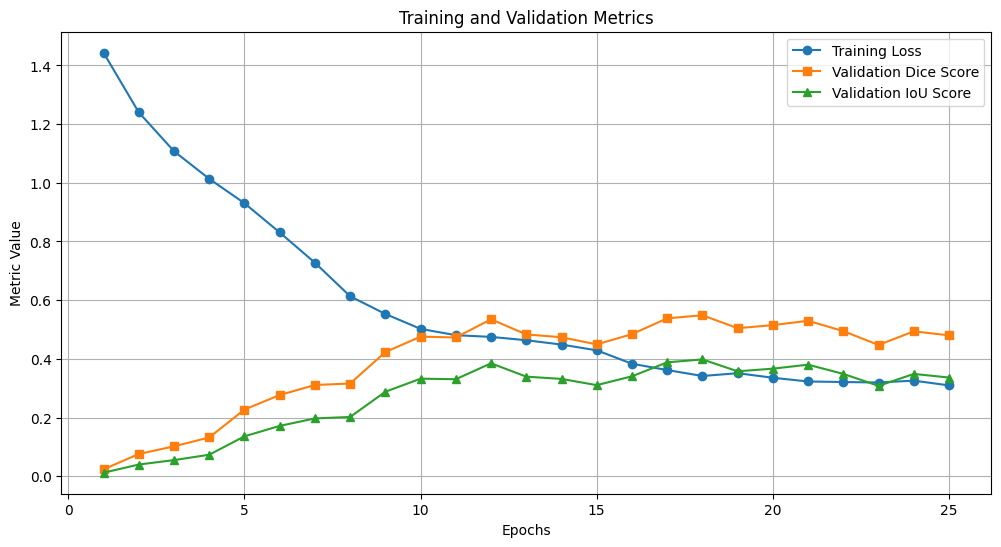

In [12]:
plot_metrics(federated_trainer.metrics_log)

In [13]:
def plot_client_metrics(client_metrics_log, title="Client Training Metrics"):
    """
    Plots training metrics for each client.

    Args:
        client_metrics_log (dict): Dictionary containing metrics for each client.
            Expected format:
            {
                client_id: {"train_losses": [list of losses for each epoch]},
                ...
            }
        title (str): Title for the plot.
    """
    plt.figure(figsize=(12, 8))
    for client_id, metrics in client_metrics_log.items():
        epochs = range(1, len(metrics["train_losses"]) + 1)
        plt.plot(epochs, metrics["train_losses"], label=f"Client {client_id} Loss", marker="o")

    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()
    plt.show()


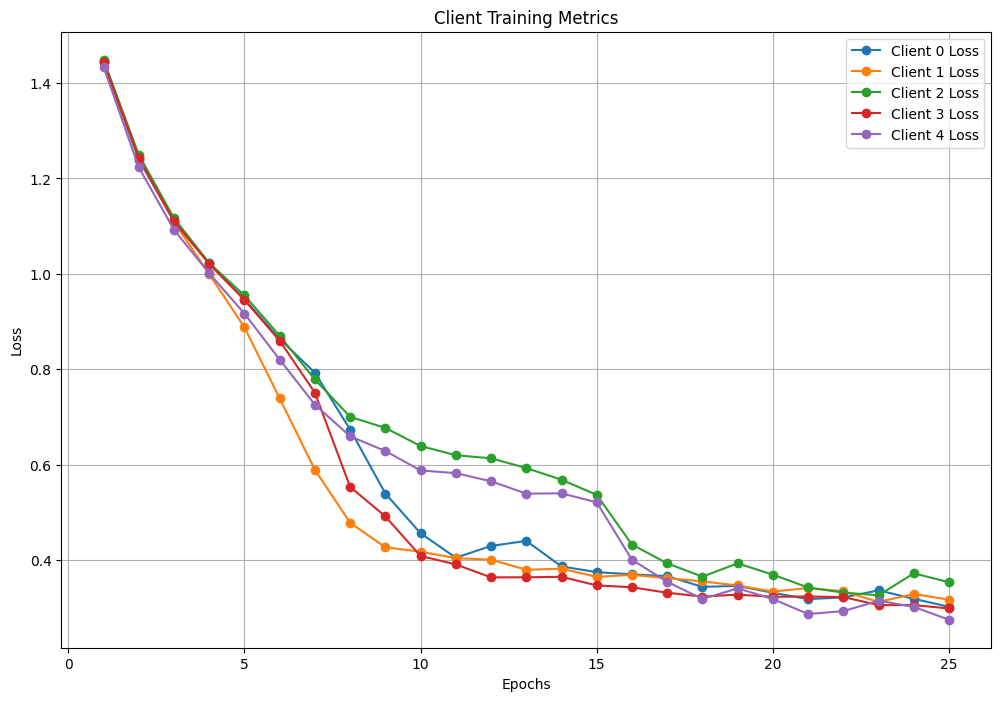

In [14]:
plot_client_metrics(federated_trainer.client_metrics_log)

In [15]:
model = federated_trainer.model
model_path = "unet3d_weights.pth"
torch.save(model.state_dict(), model_path)
print(f"Model weights saved to {model_path}")

Model weights saved to unet3d_weights.pth


In [16]:
import matplotlib.pyplot as plt

def visualize_predictions(val_loader, model, device="cuda", threshold=0.5):
    """
    Visualize images, ground truth masks, and model-predicted masks from the validation data loader.

    Args:
        val_loader (DataLoader): DataLoader for the validation dataset.
        model (torch.nn.Module): Trained PyTorch model for segmentation.
        device (str): Device to run the model on ("cuda" or "cpu").
        threshold (float): Threshold for binarizing predicted probabilities.
    """
    model.eval()  # Set the model to evaluation mode

    for batch in val_loader:
        # Extract the first sample in the batch
        img = batch["image"][0].to(device).cpu().numpy()  # Shape: (C, D, H, W)
        mask = batch["mask"][0].cpu().numpy()  # Ground truth mask: (3, H, W)
        id_ = batch["Id"][0]  # ID of the sample

        print(f"Visualizing sample ID: {id_}")

        # Generate prediction
        with torch.no_grad():
            input_tensor = torch.tensor(img).unsqueeze(0).to(device)  # Add batch dimension
            outputs = model(input_tensor)
            probabilities = torch.sigmoid(outputs).squeeze(0)  # Remove batch dimension
            predicted_mask = (probabilities > threshold).float().cpu().numpy()  # Shape: (3, H, W)

        # Select the middle slice along the depth for the MRI
        middle_slice = img.shape[1] // 2

        # Plot input MRI, ground truth masks, and predicted masks
        fig, axes = plt.subplots(3, 4, figsize=(20, 15))

        # MRI middle slice
        axes[0, 0].imshow(img[0, middle_slice, :, :], cmap='gray')
        axes[0, 0].set_title(f"Input MRI (Middle Slice) - ID: {id_}")
        axes[0, 0].axis('off')

        # Ground truth masks
        for i, label in enumerate(["Whole Tumor", "Tumor Core", "Enhancing Tumor"]):
            axes[0, i + 1].imshow(mask[i, :, :], cmap='viridis')
            axes[0, i + 1].set_title(f"Ground Truth - {label}")
            axes[0, i + 1].axis('off')

        # Predicted masks
        for i, label in enumerate(["Whole Tumor", "Tumor Core", "Enhancing Tumor"]):
            axes[1, i].imshow(predicted_mask[i, :, :], cmap='viridis')
            axes[1, i].set_title(f"Predicted - {label}")
            axes[1, i].axis('off')

        # Overlay Ground Truth vs Prediction
        for i, label in enumerate(["Whole Tumor", "Tumor Core", "Enhancing Tumor"]):
            axes[2, i].imshow(mask[i, :, :], cmap='viridis', alpha=0.5)
            axes[2, i].imshow(predicted_mask[i, :, :], cmap='cool', alpha=0.5)
            axes[2, i].set_title(f"Overlay - {label}")
            axes[2, i].axis('off')

        # Turn off any unused axes
        axes[2, 3].axis('off')

        plt.tight_layout()
        plt.show()
        break  # Visualize only the first batch


Visualizing sample ID: BraTS20_Training_101


TypeError: Invalid shape (155, 240, 240) for image data

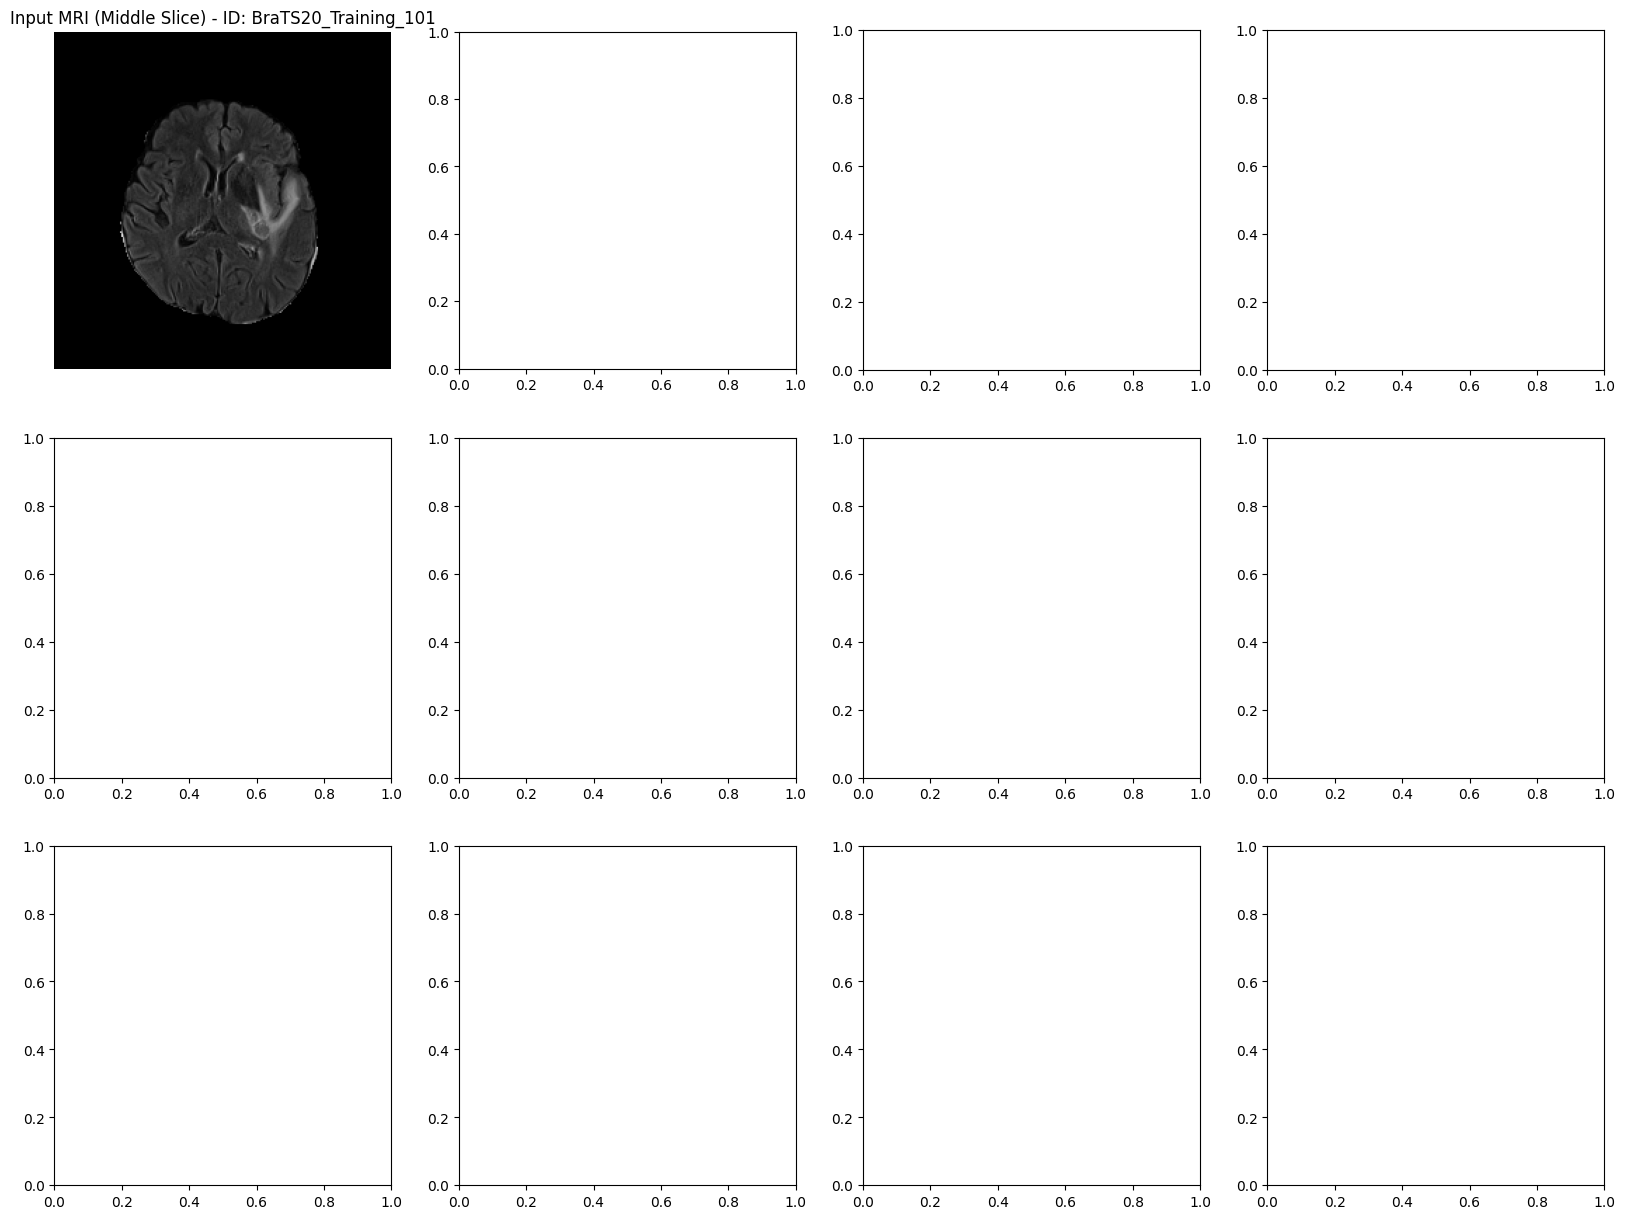

In [17]:
# Access the global model from FederatedTrainer


# Visualize predictions from the validation loader
visualize_predictions(val_dataloader, model, device="cuda", threshold=0.3)